# Visualizing GradMaps

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sys import version as python_version
from argparser import argparser
from resnet import ResNet18
from utils import progress_bar

import os

# import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Setup Parameters

In [2]:
# args class to imitate arg-parser
class argparser():
    def __init__(self):
        self.batch_size = 32
        self.lr = 0.1
        self.num_workers = 2
        self.weight_decay = 5e-4
        self.momentum = 0.9

args = argparser()
args.batch_size

32

## Dataloader and generic functions

In [17]:
def dataloader(args):
    # Loading Data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                              shuffle=True, num_workers=args.num_workers)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                             shuffle=False, num_workers=args.num_workers)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def display_image(trainloader, classes, args):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(args.batch_size)))
    
# test the accuracy of the ResNet18    
def test(args, criterion, optimizer, testloader, classes, device,
          net, epoch, best_acc):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    # Save checkpoint
    acc = 100. * correct / total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        
trainloader, testloader, classes = dataloader(args)
# display_image(trainloader, classes, args)

Files already downloaded and verified
Files already downloaded and verified


## Declare and load pretrained ResNet
Make sure to save your "ckpt.pth" model in a folder called checkpoint

In [18]:
# Declare the net
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
net = ResNet18().to(device)

# Load checkpoint or model for eval.
assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
checkpoint = torch.load('./checkpoint/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

# see what the net looks like
# net

## Define the dataloader iterator

In [19]:
dataiter = iter(testloader)

## Iterate over the dataloader object 
This returns a batch-size amount of images. **Re-run this for a fresh batch**

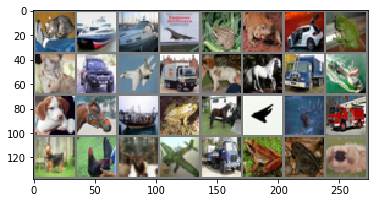

  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


In [20]:
# Take a random sample -- rerun this
# get some random training images
images, labels = dataiter.next()

# show images that were selected 
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(args.batch_size)))

## Methods to generate and visualize grad-matrices

In [21]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes_dict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

'''
Methods to iteratively backward pass over individual logits

Inputs: 
    net: pretrained network
    x: input image
    grads_matrix: An zeroed matrix of the size n_classes * num_weights
    
Outputs:
    grads_matrix: An matrix of the size n_classes * num_weights that contains the gradients wrt 
                    the output logits corresponding to each class.
'''
def get_grad_matrix(net, x, grads_matrix):
    y = net(x)
    print('Prediction:', classes[y.max(1)[1]])
    for i in range(len(classes)):
#         # Using torch.autograd
#         grads_matrix[i] = torch.autograd.grad(y1[0, i], net.layer4[1].conv2.parameters(), retain_graph=True)[0].flatten()
        
        # Alternatively, use the standard .backward()
        y[0, i].backward(retain_graph=True)        
        grads_matrix[i] = net.layer3[1].conv1.weight.grad.flatten()
        net.zero_grad() # This will make sure grads do not accumulate
        
        
'''
Methods to generate and visualize a heat map after multiplying two grad-matrices

Inputs: 
    grads_1: Grad Matrix for image 1: Size "n_classes * num_weights"
    grads_2: Grad Matrix for image 2: Size "n_classes * num_weights"
    
Outputs:
    grad_mat_cxc: The output of matrix multiplication: Size "n_classes * n_classes"
    Also generates a heatmap (Positive is light, and negative is dark)
'''      
def gen_heatmap(grads_1, grads_2):
    # Random heatmap
#     print("grads1:", grads_1.shape)
#     print("grads2", grads_2.shape)
    grad_mat_cxc = torch.matmul(grads_1, grads_2.transpose(0, 1))
    plt.imshow(grad_mat_cxc, cmap='hot', interpolation='nearest')
    plt.xticks(np.arange(10), classes, rotation=90)
    plt.yticks(np.arange(10), classes, rotation=0)
    plt.show()
    return grad_mat_cxc

'''
Utility to check if a matrix is symmetric
'''
def check_symmetric(a, rtol=1e-05, atol=1e-12):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

'''
Utility to check if two matrices are equal
'''
def check_equal(a, b, rtol=1e-05, atol=1e-8):
    return np.allclose(a, b, rtol=rtol, atol=atol)

## Visualize gradmaps from images of similar classes

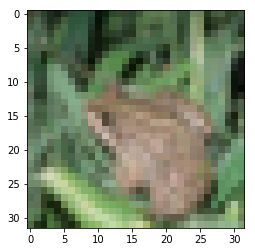

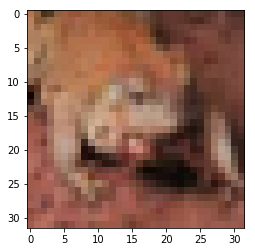

Prediction: frog
Prediction: frog


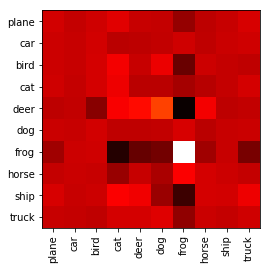

In [22]:
# rerun the cell for iter(testloader) if you get "list index out of range"
test_class = 'frog'

occurence_test_class = labels == classes.index(test_class)
positions_test_class = [i for i, n in enumerate(occurence_test_class) if n == 1]

img_1_pos = positions_test_class[0]
img_2_pos = positions_test_class[1]

# show two images from similar class
imshow(images[img_1_pos])
imshow(images[img_2_pos])
net.eval()

x1 = images[img_1_pos].to(device).unsqueeze(0) # Adding an extra batch dimension with unsqueeze
y1 = net(x1)
x2 = images[img_2_pos].to(device).unsqueeze(0)
y2 = net(x2)

# Modify the size depending the which layer weights we are using
# num_weights = 512*512*3*3
num_weights = 589824
grads_x1 = torch.zeros([len(classes), num_weights])
grads_x2 = torch.zeros([len(classes), num_weights])

get_grad_matrix(net, x1, grads_x1)
get_grad_matrix(net, x2, grads_x2)

sim_mat = gen_heatmap(grads_x1, grads_x2)

In [23]:
# i: GT label of Xi
# j: GT label of Xj
classes_dict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

sim_mat[classes_dict[test_class], classes_dict[test_class]]

tensor(72.2200)

## Visualize maps from images of different classes

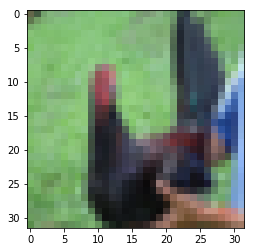

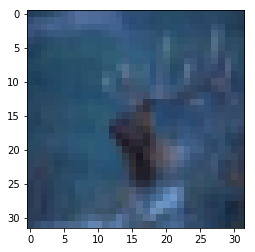

Prediction: bird
Prediction: deer


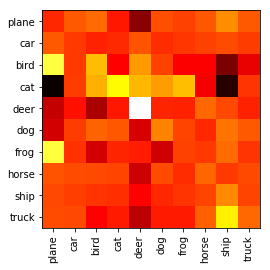

In [24]:
# Select the class for two images
test_class_1 = 'bird'
test_class_2 = 'deer'

occurence_test_class = labels == classes.index(test_class_1)
img_1_pos = [i for i, n in enumerate(occurence_test_class) if n == 1][0]

occurence_test_class = labels == classes.index(test_class_2)
img_2_pos = [i for i, n in enumerate(occurence_test_class) if n == 1][0]

# show two images from given classes class
imshow(images[img_1_pos])
imshow(images[img_2_pos])

# Set to eval mode
net.eval()

x1 = images[img_1_pos].to(device).unsqueeze(0) # Adding an extra batch dimension with unsqueeze
x2 = images[img_2_pos].to(device).unsqueeze(0)

# Modify the size depending the which layer weights we are using
num_weights = 512*512*3*3
num_weights = 589824
grads_x1 = torch.zeros([len(classes), num_weights])
grads_x2 = torch.zeros([len(classes), num_weights])

get_grad_matrix(net, x1, grads_x1)
get_grad_matrix(net, x2, grads_x2)

diff_mat = gen_heatmap(grads_x1, grads_x2)

# print(grads_x1.sum(dim=1))
# print(grads_x2.sum(dim=1))

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [25]:
classes_dict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
# i: GT label of Xi
# j: GT label of Xj

diff_mat[classes_dict[test_class_1], classes_dict[test_class_2]]

tensor(10.3821)

In [26]:
diff_mat[classes_dict[test_class_2], classes_dict[test_class_1]]

tensor(-15.8733)